# Differentiable Histograms

One of the most common data structures in HEP is the **histogram**. It is a very powerful data reduction and density estimation technique, and ubiquitous in the field.

A histogram can be thought of as a set of intervals on a 1D domain (bins), and a set of counts for each interval (yields).

We want to take the gradient of the yields with respect to the parameters that control the data (φ). But this is ill-defined -- histograms are discrete!

To illustrate this further: gradients are the language of small changes, so how do the yields change when we wiggle φ?

- events migrate between bins (discontinuous) 
- ...or stay in the same bin (zero gradient) 

So what do we do? That's the subject of this notebook :)

Check out this preprint https://arxiv.org/abs/2203.05570 for more information (section 3.2), which describes binned Kernel Density Estimates (bKDEs)

In [1]:
import relaxed
import numpy as np
import matplotlib.pyplot as plt

/Users/phinate/code/relaxed/venv/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


The trick is that instead of using a "hard" histogram function like `np.histogram` (`jnp.histogram` doesn't mean it's differentiable, but for fun you can try what happens if you use that) you would use a "relaxed" version from the `relaxed` library.

As a user you will need to specify the degree of relaxation and this is given by the "bandwidth" of the kernel density estimate. Try playing with the bandwidth parameter to see the effect.

In [2]:
inputs = np.random.normal(1, 1, size=1000)
bins = np.linspace(-10, 10, 51)
ctrs = bins[:-1] + np.diff(bins) / 2
counts_soft_p1 = relaxed.hist(inputs, bandwidth=0.5, bins=bins)
counts_soft_p2 = relaxed.hist(inputs, bandwidth=1.0, bins=bins)

counts_hard, _ = np.histogram(inputs, bins=bins)

(-5.0, 5.0)

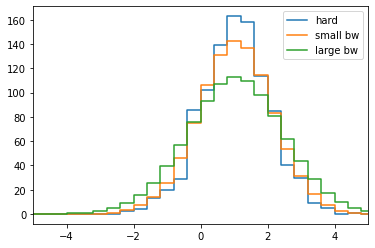

In [3]:
plt.step(ctrs, counts_hard, label="hard", where="mid")
plt.step(ctrs, counts_soft_p1, label="small bw", where="mid")
plt.step(ctrs, counts_soft_p2, label="large bw", where="mid")
plt.legend()
plt.xlim(-5, 5)

# Optimizing through histogramming


The main advantage if "soft" histograms is that you can optimize (or take gradients) throughout the histogramming operation. We will demonstrate this by doing a "gradient-based" shift of the histogram.

I.e. if you have many events $x_i$ what is the value $\Delta$ such that the peak of the histogram of  $x_i + \Delta$ is at some target value (e.g. t=3.0)

For this we will set up a loss term 

$$L(\Delta) = (\mathrm{mean}(\mathrm{histo}(x_i+\Delta)) - t)^2$$

and we will the minimize $L$ by computing gradients 

$$\partial L \over \partial \Delta$$


In [4]:
def shift_histo(factor, inputs):
    shifted_inputs = factor + inputs
    #     soft_counts,_ = jax.numpy.histogram(shifted_inputs, bins = bins)
    soft_counts = relaxed.hist(shifted_inputs, bandwidth=0.5, bins=bins)
    binned_mean = np.sum(ctrs * soft_counts / len(shifted_inputs))
    return binned_mean


def loss(param, target, inputs):
    binned_mean = shift_histo(param, inputs)
    loss = (binned_mean - target) ** 2
    return loss

0.03999973 3.813362


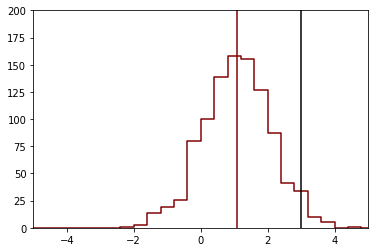

0.43584463 2.4208689


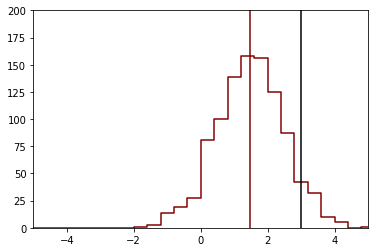

0.8111897 1.3868867


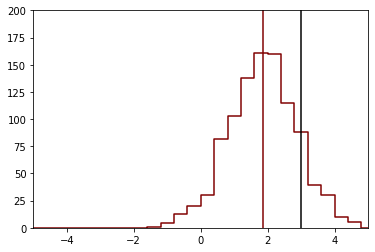

1.1473362 0.70025396


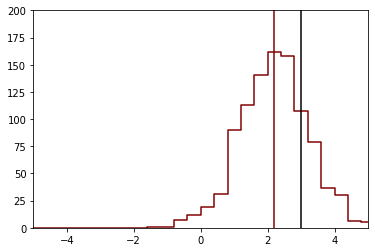

1.4287082 0.30187032


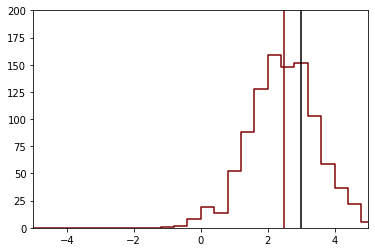

1.6462675 0.105829075


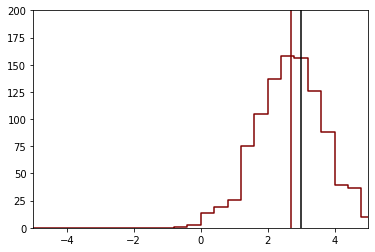

1.7993325 0.027558735


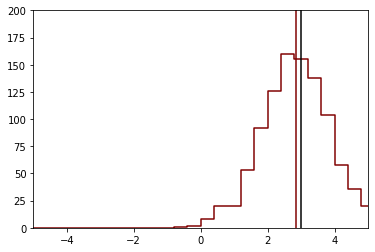

1.8951402 0.0042223423


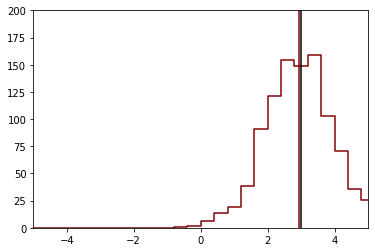

1.9462643 0.00010063023


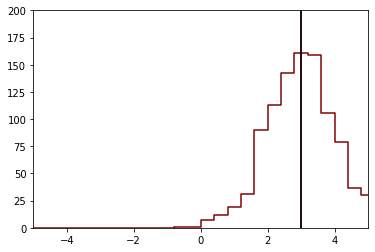

1.9670334 0.00017289053


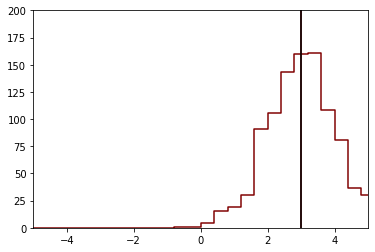

In [5]:
import jax
import optax

opt = optax.adam(4e-2)
params = 0.0
state = opt.init(params)
target = 3.0

for i in range(100):
    lvalue, g = jax.value_and_grad(loss)(params, target, inputs)
    updates, state = opt.update(g, state)
    params = optax.apply_updates(params, updates)
    if i % 10 == 0:
        print(params, lvalue)

        hard_hist = np.histogram(params + inputs, bins=bins)[0]
        hard_mean = np.sum(ctrs * hard_hist / len(inputs))
        plt.step(ctrs, hard_hist, where="mid", color="maroon")
        plt.xlim(-5, 5)
        plt.ylim(0, 200)
        plt.vlines(hard_mean, 0, 200, colors="maroon")
        plt.vlines(target, 0, 200, colors="k")
        plt.show()